In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


import requests
import zipfile
import io


In [3]:
DATASET_LINK = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'


url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall()  # Extract all files to the current directory

print("Dataset downloaded and extracted successfully.")


Dataset downloaded and extracted successfully.


In [4]:
columns=['user id','movie id','rating','timestamp']
test_df1=pd.read_csv('ml-100k/u1.test', sep='\t', header=None, names=columns)
test_df2=pd.read_csv('ml-100k/u2.test', sep='\t', header=None, names=columns)
test_df3=pd.read_csv('ml-100k/u3.test', sep='\t', header=None, names=columns)
test_df4=pd.read_csv('ml-100k/u4.test', sep='\t', header=None, names=columns)
test_df5=pd.read_csv('ml-100k/u5.test', sep='\t', header=None, names=columns)

In [5]:
columns=['user id','movie id','rating','timestamp']
base_df1=pd.read_csv('ml-100k/u1.base', sep='\t', header=None, names=columns)
base_df2=pd.read_csv('ml-100k/u2.base', sep='\t', header=None, names=columns)
base_df3=pd.read_csv('ml-100k/u3.base', sep='\t', header=None, names=columns)
base_df4=pd.read_csv('ml-100k/u4.base', sep='\t', header=None, names=columns)
base_df5=pd.read_csv('ml-100k/u5.base', sep='\t', header=None, names=columns)

In [6]:
columns_movie = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = columns_movie.split(' | ')

items_dataset = pd.read_csv('ml-100k/u.item', sep='|', header=None, names=column_names2, encoding='latin-1')
items_dataset.head()


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
for i in range(1, 6):
    base_df_name = f'base_df{i}'
    test_df_name = f'test_df{i}'
    globals()[base_df_name] = pd.merge(items_dataset, globals()[f'base_df{i}'], on='movie id')
    globals()[test_df_name] = pd.merge(items_dataset, globals()[f'test_df{i}'], on='movie id')
    globals()[base_df_name]['rating_timestamp'] = pd.to_datetime(globals()[base_df_name]['timestamp'], unit='s')
    globals()[test_df_name]['rating_timestamp'] = pd.to_datetime(globals()[test_df_name]['timestamp'], unit='s')

In [8]:
for i in range(1, 6):
    base_df_name = f'base_df{i}'
    test_df_name = f'test_df{i}'
    globals()[base_df_name]['release_year'] = globals()[base_df_name]['release date'].str.strip().str[-4:]
    globals()[test_df_name]['release_year'] = globals()[test_df_name]['release date'].str.strip().str[-4:]
    globals()[base_df_name].drop(['video release date','timestamp','release date'],axis=1,inplace=True)
    globals()[test_df_name].drop(['video release date','timestamp','release date'],axis=1,inplace=True)

In [9]:
column_names3 = ['user id', 'age', 'gender', 'occupation', 'zip code']
demographics_df= pd.read_csv('ml-100k/u.user', sep='|', header=None, names=column_names3)

In [10]:
for i in range(1, 6):
    base_df_name = f'base_df{i}'
    test_df_name = f'test_df{i}'
    globals()[base_df_name] = pd.merge(demographics_df, globals()[f'base_df{i}'], on='user id')
    globals()[test_df_name] = pd.merge(demographics_df, globals()[f'test_df{i}'], on='user id')

In [11]:
bins = [0, 25, 35, 45, 55, 65, 100]
labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '65+']
for i in range(1, 6):
    base_df_name = f'base_df{i}'
    test_df_name = f'test_df{i}'
    globals()[base_df_name]['age_group'] = pd.cut(globals()[base_df_name]['age'],bins=bins, labels=labels)
    globals()[test_df_name]['age_group'] = pd.cut(globals()[test_df_name]['age'],bins=bins, labels=labels)


In [12]:
for i in range(1, 6):
    base_df_name = f'base_df{i}'
    test_df_name = f'test_df{i}'
    globals()[base_df_name].drop(['age'],axis=1,inplace=True)
    globals()[test_df_name].drop(['age'],axis=1,inplace=True)

In [13]:
base_df1.head()

,user id,gender,occupation,zip code,movie id,movie title,IMDb URL,unknown,Action,Adventure,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating,rating_timestamp,release_year,age_group
0,1,M,technician,85711,1,Toy Story (1995),http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,...,0,0,0,0,0,0,5,1997-09-22 22:02:38,1995,0-25
1,1,M,technician,85711,2,GoldenEye (1995),http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,...,0,0,0,1,0,0,3,1997-10-15 05:26:11,1995,0-25
2,1,M,technician,85711,3,Four Rooms (1995),http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,...,0,0,0,1,0,0,4,1997-11-03 07:42:40,1995,0-25
3,1,M,technician,85711,4,Get Shorty (1995),http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,...,0,0,0,0,0,0,3,1997-10-15 05:25:19,1995,0-25
4,1,M,technician,85711,5,Copycat (1995),http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,...,0,0,0,1,0,0,3,1998-03-13 01:15:12,1995,0-25


**Collaborative Based Filtering**

**Matrix Factorization**

For latent factors: 50
RMSEs: [0.5575955796985352, 0.5644421407735485, 0.5651744236114917, 0.5623271622016875, 0.5598875133381224]
Precision: [0.06666666666666654, 0.04441041347626331, 0.03958573072497118, 0.0364030335861321, 0.029989212513484298]
Recall: [0.008284004112657005, 0.008199658795608555, 0.011052088524556065, 0.009376514660055594, 0.006408110565327279]
Hit Rate: [0.26143790849673204, 0.1776416539050536, 0.17376294591484465, 0.15384615384615385, 0.12944983818770225]
---------------------------------------------------------------------------------------------------
For latent factors: 60
RMSEs: [0.5394872224692373, 0.545862300438132, 0.5466888685819928, 0.5442137674173856, 0.5415454630349683]
Precision: [0.0644880174291938, 0.05053598774885138, 0.04165707710011504, 0.035536294691224206, 0.03279395900755117]
Recall: [0.007690689931838283, 0.00867930527689459, 0.0108195272802299, 0.008232957259557855, 0.00731149526017011]
Hit Rate: [0.25054466230936817, 0.20520673813169985, 0.1

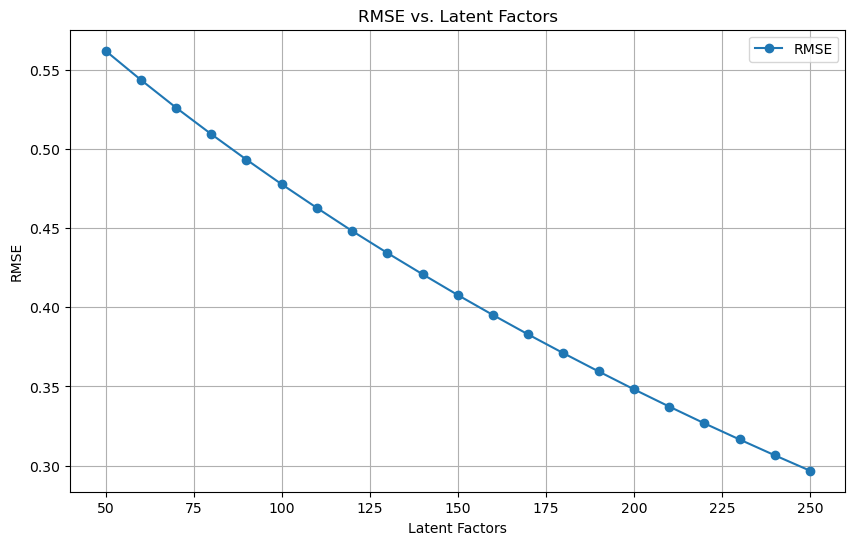

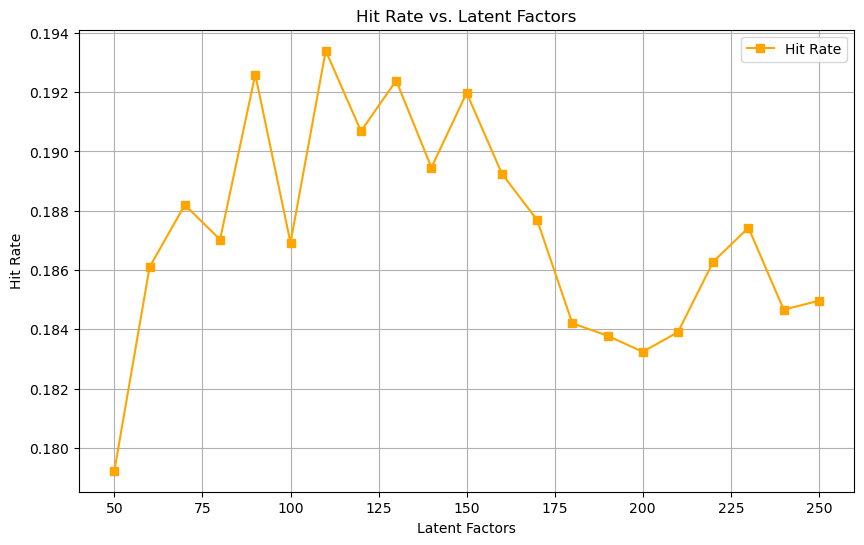

In [16]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

base_dfs = [base_df1, base_df2, base_df3, base_df4, base_df5]
test_dfs = [test_df1, test_df2, test_df3, test_df4, test_df5]

def evaluate_recommender(user_id, test_df, reconstructed_matrix, user_item_matrix, top_n=5):
    user_index = user_item_matrix.index.get_loc(user_id)
    user_ratings = reconstructed_matrix[user_index, :]
    true_ratings = test_df[test_df['user id'] == user_id][['movie id', 'rating']]
    top_n_predictions = np.argsort(user_ratings)[::-1][:top_n]
    recommended_movies = set(test_df.iloc[top_n_predictions]['movie id'])
    relevant_items = set(true_ratings['movie id'])
    hits = len(recommended_movies.intersection(relevant_items))
    precision = hits / top_n
    recall = hits / len(relevant_items) if relevant_items else 0
    hit_rate = 1 if hits > 0 else 0
    return precision, recall, hit_rate

def evaluate_matrix_factorization(base_dfs, test_dfs, latent_features=[50]):
    errors = []
    precisions = []
    recalls = []
    hit_rates = []

    for base_df, test_df in zip(base_dfs, test_dfs):
        user_item_matrix = base_df.pivot_table(index='user id', columns='movie id', values='rating')
        user_item_matrix = user_item_matrix.fillna(0)

        for k in latent_features:
            svd = TruncatedSVD(n_components=k, random_state=42)
            user_features = svd.fit_transform(user_item_matrix)
            item_features = svd.components_
            reconstructed_matrix = np.dot(user_features, item_features)
            mse = mean_squared_error(user_item_matrix.values.flatten(), reconstructed_matrix.flatten())
            rmse = np.sqrt(mse)
            errors.append(rmse)

            precision_total = recall_total = hit_rate_total = 0
            for user_id in test_df['user id'].unique():
                precision, recall, hit_rate = evaluate_recommender(user_id, test_df, reconstructed_matrix, user_item_matrix)
                precision_total += precision
                recall_total += recall
                hit_rate_total += hit_rate

            num_users = len(test_df['user id'].unique())
            avg_precision = precision_total / num_users
            avg_recall = recall_total / num_users
            avg_hit_rate = hit_rate_total / num_users

            precisions.append(avg_precision)
            recalls.append(avg_recall)
            hit_rates.append(avg_hit_rate)

    return errors, precisions, recalls, hit_rates

# Plotting results
latent_factors = range(50, 251, 10)
all_rmse = []
all_hit_rates = []

for i in latent_factors:
    print(f"For latent factors: {i}")
    latent_features = [i]
    errors, precisions, recalls, hit_rates = evaluate_matrix_factorization(base_dfs, test_dfs, latent_features)

    avg_rmse = np.mean(errors)
    avg_hit_rate = np.mean(hit_rates)

    print(f"RMSEs: {errors}")
    print(f"Precision: {precisions}")
    print(f"Recall: {recalls}")
    print(f"Hit Rate: {hit_rates}")
    print("---------------------------------------------------------------------------------------------------")

    all_rmse.append(avg_rmse)
    all_hit_rates.append(avg_hit_rate)

# Plot RMSE for different latent factors
plt.figure(figsize=(10, 6))
plt.plot(latent_factors, all_rmse, marker='o', label='RMSE')
plt.title('RMSE vs. Latent Factors')
plt.xlabel('Latent Factors')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.show()

# Print Hit Rate for each latent factor
plt.figure(figsize=(10, 6))
plt.plot(latent_factors, all_hit_rates, marker='s', color='orange', label='Hit Rate')
plt.title('Hit Rate vs. Latent Factors')
plt.xlabel('Latent Factors')
plt.ylabel('Hit Rate')
plt.grid()
plt.legend()
plt.show()


In [15]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

base_dfs = [base_df1, base_df2, base_df3, base_df4, base_df5]
test_dfs = [test_df1, test_df2, test_df3, test_df4, test_df5]

def evaluate_recommender(user_id, test_df, reconstructed_matrix, user_item_matrix, top_n=50):
    user_index = user_item_matrix.index.get_loc(user_id)
    user_ratings = reconstructed_matrix[user_index, :]
    true_ratings = test_df[test_df['user id'] == user_id][['movie id', 'rating']]
    top_n_predictions = np.argsort(user_ratings)[::-1][:top_n]
    recommended_movie_ids = user_item_matrix.columns[top_n_predictions].tolist()
    relevant_items = set(true_ratings['movie id'])
    hits = len(set(recommended_movie_ids).intersection(relevant_items))
    
    precision = hits / top_n if top_n > 0 else 0
    recall = hits / len(relevant_items) if len(relevant_items) > 0 else 0
    hit_rate = hits / len(relevant_items) if len(relevant_items) > 0 else 0  # Fractional hit rate

    return precision, recall, hit_rate

def evaluate_matrix_factorization(base_dfs, test_dfs, latent_features=[50]):
    errors = []
    precisions = []
    recalls = []
    hit_rates = []

    for base_df, test_df in zip(base_dfs, test_dfs):
        user_item_matrix = base_df.pivot_table(index='user id', columns='movie id', values='rating')
        user_item_matrix = user_item_matrix.fillna(0)

        for k in latent_features:
            svd = TruncatedSVD(n_components=k, random_state=42)
            user_features = svd.fit_transform(user_item_matrix)
            item_features = svd.components_
            reconstructed_matrix = np.dot(user_features, item_features)
            mse = mean_squared_error(user_item_matrix.values.flatten(), reconstructed_matrix.flatten())
            rmse = np.sqrt(mse)
            errors.append(rmse)

            precision_total = recall_total = hit_rate_total = 0

            for user_id in test_df['user id'].unique():
                precision, recall, hit_rate = evaluate_recommender(user_id, test_df, reconstructed_matrix, user_item_matrix)
                precision_total += precision
                recall_total += recall
                hit_rate_total += hit_rate

            num_users = len(test_df['user id'].unique())
            avg_precision = precision_total / num_users
            avg_recall = recall_total / num_users
            avg_hit_rate = hit_rate_total / num_users

            precisions.append(avg_precision)
            recalls.append(avg_recall)
            hit_rates.append(avg_hit_rate)

    return errors, precisions, recalls, hit_rates

for i in range(50, 251, 10):
    print(f"for latent factors: {i}")
    latent_features = [i]
    errors, precisions, recalls, hit_rates = evaluate_matrix_factorization(base_dfs, test_dfs, latent_features)

    print(f"RMSEs: {errors}")
    print(f"Precision: {precisions}")
    print(f"Recall: {recalls}")
    print(f"Hit Rate: {hit_rates}")

    print("---------------------------------------------------------------------------------------------------")


for latent factors: 50
RMSEs: [0.5575955796985352, 0.5644421407735485, 0.5651744236114917, 0.5623271622016875, 0.5598875133381224]
Precision: [0.12370370370370377, 0.08667687595712095, 0.07123130034522425, 0.06738894907908968, 0.0707011866235165]
Recall: [0.29818441562233744, 0.2989830878203592, 0.3049021908028337, 0.29299743879466694, 0.30127072692374773]
Hit Rate: [0.29818441562233744, 0.2989830878203592, 0.3049021908028337, 0.29299743879466694, 0.30127072692374773]
---------------------------------------------------------------------------------------------------
for latent factors: 60
RMSEs: [0.5394872224692373, 0.545862300438132, 0.5466888685819928, 0.5442137674173856, 0.5415454630349683]
Precision: [0.11080610021786509, 0.07632465543644709, 0.06370540851553497, 0.05997833152762712, 0.06306364617044215]
Recall: [0.2810911372181978, 0.27712677262347357, 0.2855293149052812, 0.2706430283357417, 0.2774643484527043]
Hit Rate: [0.2810911372181978, 0.27712677262347357, 0.2855293149052812

KeyboardInterrupt: 


Cross-Validation Results for Different k Values:
    fold    k  precision   recall  hit_rate      rmse
0      1   25   0.001569  0.00090  0.039216  0.917397
1      1   50   0.003050  0.00350  0.152505  0.981169
2      1  100   0.005904  0.01355  0.590414  1.086514
3      2   25   0.001348  0.00110  0.033691  0.946024
4      2   50   0.002450  0.00400  0.122511  1.030085
5      2  100   0.005329  0.01740  0.532925  1.165612
6      3   25   0.000829  0.00090  0.020713  0.979843
7      3   50   0.001473  0.00320  0.073648  1.088020
8      3  100   0.003003  0.01305  0.300345  1.257980
9      4   25   0.000910  0.00105  0.022752  0.982490
10     4   50   0.001322  0.00305  0.066089  1.094275
11     4  100   0.002828  0.01305  0.282774  1.270541
12     5   25   0.000949  0.00110  0.023732  0.986668
13     5   50   0.001467  0.00340  0.073355  1.099387
14     5  100   0.003172  0.01470  0.317152  1.274144

Average Metrics Across Folds for Each k:
     fold  precision   recall  hit_rate     

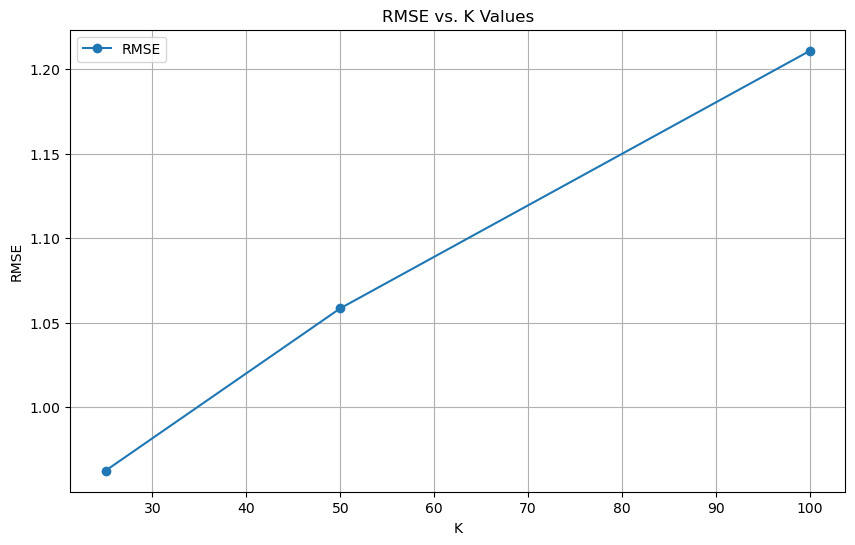

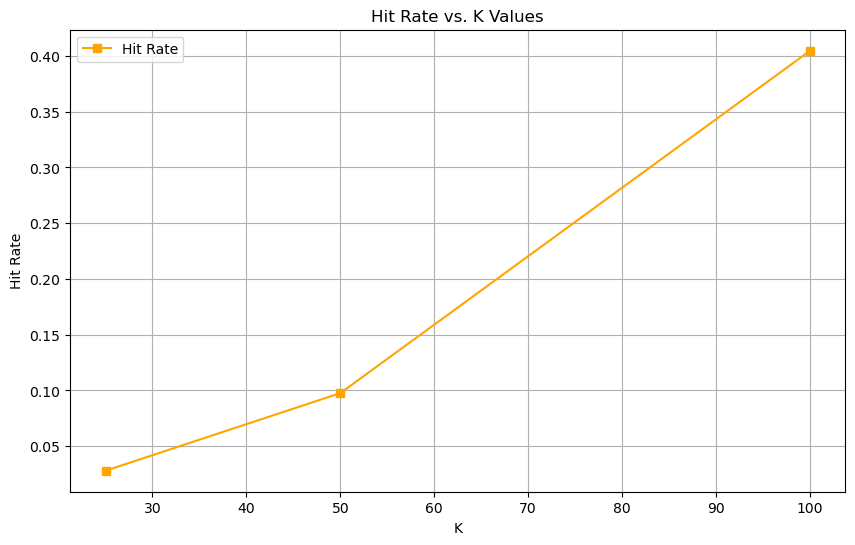

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Placeholder datasets
base_dfs = [base_df1, base_df2, base_df3, base_df4, base_df5]
test_dfs = [test_df1, test_df2, test_df3, test_df4, test_df5]

def build_user_item_matrix(df):
    return df.pivot_table(index='user id', columns='movie id', values='rating', fill_value=0)

def predict_ratings(user_id, user_item_matrix, item_similarity_df, k=1000):
    user_ratings = user_item_matrix.loc[user_id]
    similar_items = item_similarity_df[user_ratings[user_ratings > 0].index]
    weighted_sum = (similar_items * user_ratings[user_ratings > 0].values).sum(axis=1)
    similarity_sum = similar_items.sum(axis=1)
    predicted_ratings = weighted_sum / similarity_sum
    return predicted_ratings.sort_values(ascending=False).head(k)

def evaluate_metrics(test_df, recommendations, reconstructed_matrix, user_item_matrix):
    test_grouped = test_df.groupby('user id')['movie id'].apply(list).to_dict()
    hits, total_relevant, total_recommended = 0, 0, 0

    # Compute RMSE
    true_ratings = user_item_matrix.values.flatten()
    predicted_ratings = reconstructed_matrix.flatten()
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

    for user_id, recs in recommendations.items():
        relevant_items = set(test_grouped.get(user_id, []))
        recommended_items = set(recs)

        hits += len(relevant_items & recommended_items)
        total_relevant += len(relevant_items)
        total_recommended += len(recommended_items)

    precision = hits / total_recommended if total_recommended > 0 else 0
    recall = hits / total_relevant if total_relevant > 0 else 0
    hit_rate = hits / len(test_grouped) if len(test_grouped) > 0 else 0

    return precision, recall, hit_rate, rmse

kf_results = []

k_values = [25, 50, 100]
rmse_values = []

for i in range(5):
    train_df = base_dfs[i]
    test_df = test_dfs[i]

    user_item_matrix = build_user_item_matrix(train_df)
    item_similarity = cosine_similarity(user_item_matrix.T)
    item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    for k in k_values:
        recommendations = {}
        reconstructed_matrix = np.zeros(user_item_matrix.shape)

        for user_id in test_df['user id'].unique():
            try:
                pred_ratings = predict_ratings(user_id, user_item_matrix, item_similarity_df, k=k)
                recommendations[user_id] = pred_ratings.index.tolist()

                # Map movie IDs to column indices in the matrix
                movie_indices = [user_item_matrix.columns.get_loc(movie_id) for movie_id in pred_ratings.index]
                user_index = user_item_matrix.index.get_loc(user_id)
                
                reconstructed_matrix[user_index, movie_indices] = pred_ratings.values
            except KeyError:
                recommendations[user_id] = []

        precision, recall, hit_rate, rmse = evaluate_metrics(test_df, recommendations, reconstructed_matrix, user_item_matrix)
        kf_results.append({'fold': i + 1, 'k': k, 'precision': precision, 'recall': recall, 'hit_rate': hit_rate, 'rmse': rmse})
        rmse_values.append(rmse)

kf_results_df = pd.DataFrame(kf_results)
print("\nCross-Validation Results for Different k Values:")
print(kf_results_df)

print("\nAverage Metrics Across Folds for Each k:")
print(kf_results_df.groupby('k').mean())

# Plot RMSE for different k values
avg_rmse = kf_results_df.groupby('k')['rmse'].mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_rmse.index, avg_rmse.values, marker='o', label='RMSE')
plt.title('RMSE vs. K Values')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.show()

# Plot Hit Rate for different k values
avg_hit_rate = kf_results_df.groupby('k')['hit_rate'].mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_hit_rate.index, avg_hit_rate.values, marker='s', color='orange', label='Hit Rate')
plt.title('Hit Rate vs. K Values')
plt.xlabel('K')
plt.ylabel('Hit Rate')
plt.grid()
plt.legend()
plt.show()



Cross-Validation Results for Different k Values:
    fold   k  precision   recall   hit_rate      rmse
0      1   5        1.0  0.11245   4.899782  1.041533
1      1  10        1.0  0.21515   9.374728  1.041533
2      1  20        1.0  0.37105  16.167756  1.041533
3      2   5        1.0  0.15850   4.854518  1.028685
4      2  10        1.0  0.28975   8.874426  1.028685
5      2  20        1.0  0.47765  14.629403  1.028685
6      3   5        1.0  0.20270   4.665132  1.059502
7      3  10        1.0  0.35410   8.149597  1.059502
8      3  20        1.0  0.55805  12.843498  1.059502
9      4   5        1.0  0.21070   4.565547  1.071641
10     4  10        1.0  0.36555   7.920910  1.071641
11     4  20        1.0  0.56580  12.260022  1.071641
12     5   5        1.0  0.20775   4.482201  1.075233
13     5  10        1.0  0.35830   7.730313  1.075233
14     5  20        1.0  0.54905  11.845739  1.075233

Average Metrics Across Folds for Each k:
    fold  precision   recall   hit_rate     

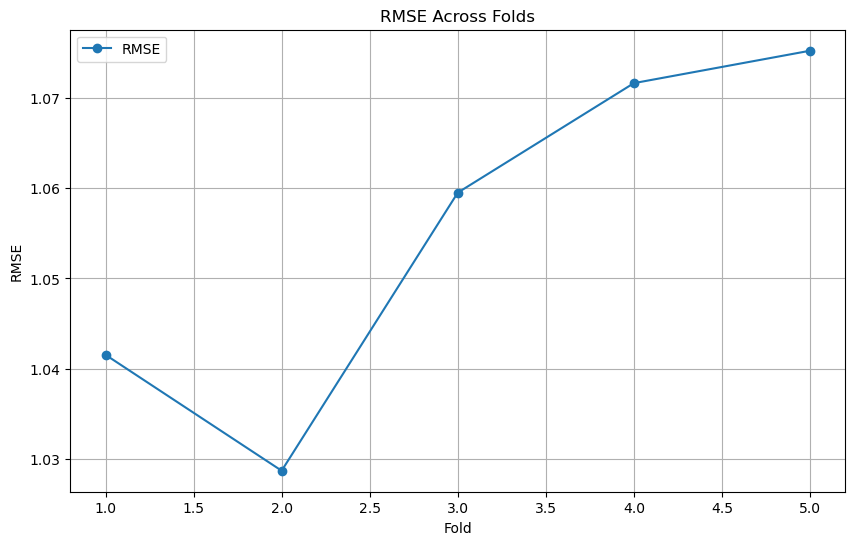

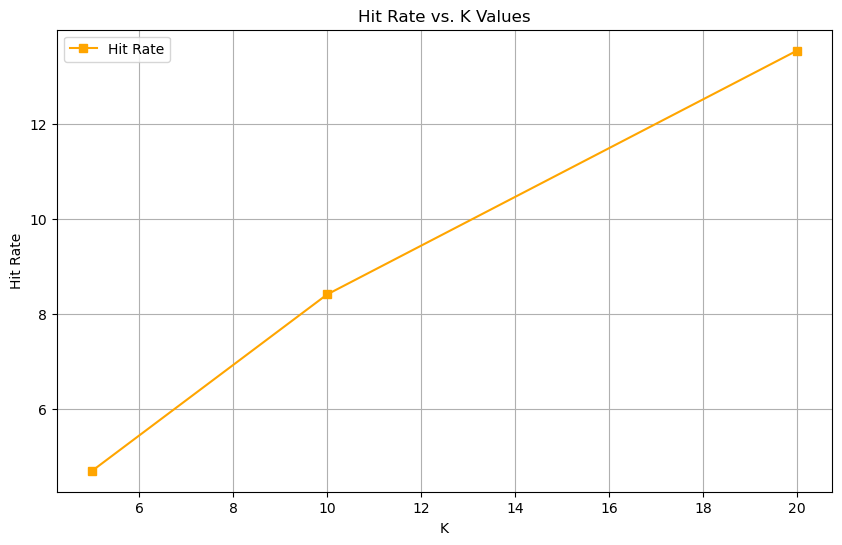

In [23]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Placeholder datasets
base_dfs = [base_df1, base_df2, base_df3, base_df4, base_df5]
test_dfs = [test_df1, test_df2, test_df3, test_df4, test_df5]

def preprocess_data(df):
    user_encoder = LabelEncoder()
    movie_encoder = LabelEncoder()
    occupation_encoder = LabelEncoder()
    age_group_encoder = LabelEncoder()
    
    df['user id'] = user_encoder.fit_transform(df['user id'])
    df['movie id'] = movie_encoder.fit_transform(df['movie id'])
    df['occupation'] = occupation_encoder.fit_transform(df['occupation'])
    df['age_group'] = age_group_encoder.fit_transform(df['age_group'])
    
    return df, user_encoder, movie_encoder, occupation_encoder, age_group_encoder

def evaluate_metrics(test_df, recommendations, k=10):
    test_grouped = test_df.groupby('user id')['movie id'].apply(list).to_dict()
    hits, total_relevant, total_recommended = 0, 0, 0
    
    for user_id, recs in recommendations.items():
        relevant_items = set(test_grouped.get(user_id, []))
        recommended_items = set(recs)
        
        hits += len(relevant_items & recommended_items)
        total_relevant += len(relevant_items)
        total_recommended += len(recommended_items)
    
    precision = hits / total_recommended if total_recommended > 0 else 0
    recall = hits / total_relevant if total_relevant > 0 else 0
    hit_rate = hits / len(test_grouped) if len(test_grouped) > 0 else 0
    
    return precision, recall, hit_rate

kf_results = []
rmse_values = []

k_values = [5, 10, 20]

for i in range(5):
    train_df, user_encoder, movie_encoder, occupation_encoder, age_group_encoder = preprocess_data(base_dfs[i])
    test_df, _, _, _, _ = preprocess_data(test_dfs[i])
    
    X_train = train_df[['user id', 'movie id', 'occupation', 'age_group']]  # Features
    y_train = train_df['rating']
    X_test = test_df[['user id', 'movie id', 'occupation', 'age_group']]
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    
    test_df['predicted_rating'] = model.predict(X_test)
    predictions = test_df['predicted_rating'].values
    true_ratings = test_df['rating'].values
    rmse = np.sqrt(mean_squared_error(true_ratings, predictions))
    rmse_values.append(rmse)

    for k in k_values:
        recommendations = {}
        for user_id in test_df['user id'].unique():
            top_k_recs = test_df[test_df['user id'] == user_id].nlargest(k, 'predicted_rating')[['movie id']].values.flatten().tolist()
            recommendations[user_id] = top_k_recs
        
        precision, recall, hit_rate = evaluate_metrics(test_df, recommendations, k=k)
        kf_results.append({'fold': i + 1, 'k': k, 'precision': precision, 'recall': recall, 'hit_rate': hit_rate, 'rmse': rmse})

kf_results_df = pd.DataFrame(kf_results)
print("\nCross-Validation Results for Different k Values:")
print(kf_results_df)

print("\nAverage Metrics Across Folds for Each k:")
print(kf_results_df.groupby('k').mean())

# Plot RMSE across folds
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), rmse_values, marker='o', label='RMSE')
plt.title('RMSE Across Folds')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.show()

# Plot Hit Rate for different k values
avg_hit_rate = kf_results_df.groupby('k')['hit_rate'].mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_hit_rate.index, avg_hit_rate.values, marker='s', color='orange', label='Hit Rate')
plt.title('Hit Rate vs. K Values')
plt.xlabel('K')
plt.ylabel('Hit Rate')
plt.grid()
plt.legend()
plt.show()
